In [1]:
from gernerate_data import load_clas_seg_data
import tensorflow as tf
from sklearn.metrics import classification_report, auc, roc_curve
from keras.utils.np_utils import *
from keras.callbacks import LearningRateScheduler
from models.shareLayer import create_pair_model
from sklearn.preprocessing import LabelBinarizer, label_binarize
from utils.losses import dice_coef_loss, dice_coef, dice_p_bce, dice_p_focal, tversky_loss, focal_loss, focal_tversky, \
    p_r_f1_iou, generalized_dice_coeff, generalized_dice_loss
from keras.losses import categorical_crossentropy, mean_squared_error, binary_crossentropy
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras.backend as K
import utils_paths
import numpy as np
import pickle
import os

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:

INIT_LR = 3e-4
EPOCHS =200
batch_size = 8
depth = 3
img_size = 224
Name = "shareLayer2_5e-4"
GPU = True
target = (img_size, img_size)

if GPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "1, 3"


    
print("------------------------------------------------ Preparing model ------------------------------------------------")
model = create_pair_model(img_size, img_size, depth, nClasses=2)
model.summary()

------------------------------------------------ Preparing model ------------------------------------------------
Instructions for updating:
Colocations handled automatically by placer.


2022-03-23 04:29:04.494813: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-03-23 04:29:04.525186: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200095000 Hz
2022-03-23 04:29:04.529286: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x624e690 executing computations on platform Host. Devices:
2022-03-23 04:29:04.529357: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-03-23 04:29:05.641124: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x62d0380 executing computations on platform CUDA. Devices:
2022-03-23 04:29:05.641192: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-03-23 04:29:05.641209: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (1): Tesla V100-PCIE-32GB

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cls_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
seg_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
share_conv1_1 (Conv2D)          (None, 224, 224, 64) 1792        cls_input[0][0]                  
                                                                 seg_input[0][0]                  
_____________________________________________________________________________________________

In [3]:
# trainX_dir = 'dataset/LE/test/images/'
trainX_dir = 'dataset/Dataset_BUSI_AN/train/images/'
valX_dir = trainX_dir.replace('train', 'val')
testX_dir = trainX_dir.replace('train', 'test')


train_x,  train_c_y, train_s_y = load_clas_seg_data(trainX_dir, target)
val_x, val_c_y, val_s_y = load_clas_seg_data(valX_dir, target)
test_x, test_c_y, test_s_y = load_clas_seg_data(testX_dir, target)


lb = LabelBinarizer()
train_c_y = lb.fit_transform(train_c_y)
val_c_y = lb.fit_transform(val_c_y)
test_c_y = lb.fit_transform(test_c_y)
train_c_y = to_categorical(train_c_y, 2)
val_c_y = to_categorical(val_c_y, 2)
test_c_y = to_categorical(test_c_y, 2)

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (433).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (433).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (369).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (369).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (168).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (168).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (5).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (5).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (382).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (382).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (22).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (22).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (20)_f64b8314-0c53-45e0-8265-7125276bee20.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (20)_f64b8314-0c53-45e0-8265-7125276bee20.

dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (427).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (197).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (197).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (96).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (96).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (277).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (277).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (164).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (164).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (2)_3f841cfb-612f-45a0-81bd-6fa37e2501f7.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (2)_3f841cfb-612f-45a0-81bd-6fa37e2501f7.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (55).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (55).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (246).

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (125).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (125).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (333)_f169f971-65ad-4bff-bc63-5be391b93041.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (333)_f169f971-65ad-4bff-bc63-5be391b93041.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (232)_93b61296-2aa2-455d-aa48-9decd057f75c.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (232)_93b61296-2aa2-455d-aa48-9decd057f75c.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (259).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (259).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (126)_a8650165-da8e-4017-9ea4-0a35b1df49cf.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (126)_a8650165-da8e-4017-9ea4-0a35b1df49cf.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (351).png
dataset/Dataset_BUSI_AN/train/masks/beng

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (74).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (74).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (31)_743673fa-0499-4f23-93a0-e4b83c22df9d.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (31)_743673fa-0499-4f23-93a0-e4b83c22df9d.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (135).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (135).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (356).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (356).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (87)_c93fe34d-eff8-4aa3-b964-12ce8fde9a52.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (87)_c93fe34d-eff8-4aa3-b964-12ce8fde9a52.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (115)_61128333-c506-4dea-a2ae-8674f802d199.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (115)_61128333-c506-4dea-a2

dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (61).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (273).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (273).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (23).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (23).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (87).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (87).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (238).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (238).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (255)_2a785671-7051-478b-82e0-0bb785d7d1b0.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (255)_2a785671-7051-478b-82e0-0bb785d7d1b0.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (418).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (418).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (39

dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (99).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (245)_2e6b0b6d-f196-4257-b016-67edf9118151.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (245)_2e6b0b6d-f196-4257-b016-67edf9118151.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (328)_3c7f9602-3b56-44ed-b61a-c4cac18d73af.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (328)_3c7f9602-3b56-44ed-b61a-c4cac18d73af.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (248).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (248).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (204).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (204).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (379)_17204149-ad02-4796-9335-251009d8860b.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (379)_17204149-ad02-4796-9335-251009d8860b.png
dataset/Dataset_BUSI_AN/train/images/bengin

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (332).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (332).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (143).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (143).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (181).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (181).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (129)_9c3fef8c-e187-46be-b396-46e6de00288c.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (129)_9c3fef8c-e187-46be-b396-46e6de00288c.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (116).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (116).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (424).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (424).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (359).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benig

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (428).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (428).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (296)_1da06746-b512-4513-95f6-3a0e24b3499a.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (296)_1da06746-b512-4513-95f6-3a0e24b3499a.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (157).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (157).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (225).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (225).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (294).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (294).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (203).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (203).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (336).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benig

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (421).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (421).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (95)_b98f3070-274e-49e7-ba97-f5dfc374b97a.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (95)_b98f3070-274e-49e7-ba97-f5dfc374b97a.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (67).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (67).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (234).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (234).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (402).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (402).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (256).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (256).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (398).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (3

dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (128).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (78)_cfd44f6d-6157-4a6d-8091-e165c48494ce.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (78)_cfd44f6d-6157-4a6d-8091-e165c48494ce.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (209)_20799fa0-9177-4e91-9518-2e45bc7ea5cd.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (209)_20799fa0-9177-4e91-9518-2e45bc7ea5cd.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (57)_ceefaf62-ac93-428c-86ef-dd962f98d6da.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (57)_ceefaf62-ac93-428c-86ef-dd962f98d6da.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (110)_0ff37a1b-0799-4871-9785-e692298efe81.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (110)_0ff37a1b-0799-4871-9785-e692298efe81.png
dataset/Dataset_BUSI_AN/train/images/malignant_image

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (7)_0afe7459-dc67-4611-81d2-41d5cfcd1c87.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (7)_0afe7459-dc67-4611-81d2-41d5cfcd1c87.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (41).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (41).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (206).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (206).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (31)_0e452099-4548-49db-8480-5a8cc748e51a.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (31)_0e452099-4548-49db-8480-5a8cc748e51a.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (88)_12bcebf6-57de-45e3-919b-8133c11aaab0.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (88)_12bcebf6-57de-45e3-919b-8133c11aaab0.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/mali

dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (43)_2f03e7c4-6c39-4e65-86f0-8bd2180a6260.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (68).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (68).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (141)_d75f70a9-dc74-4b25-b440-d9d815c7ef51.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (141)_d75f70a9-dc74-4b25-b440-d9d815c7ef51.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (199).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (199).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (107).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (107).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (92)_746c74e7-36b8-4207-a4f1-299e1202e6d9.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (92)_746c74e7-36b8-4207-a4f1-299e1202e6d9.png
dataset/Dataset_BU

dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (156)_6c8ee369-3f8e-45cb-b5ca-61d9bff220c7.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (204).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (204).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (181)_798c4f0a-5bc1-4d5a-8473-4fd9b36489bf.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (181)_798c4f0a-5bc1-4d5a-8473-4fd9b36489bf.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (16)_7b73ba90-0600-4287-bfd5-713b30eadb26.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (16)_7b73ba90-0600-4287-bfd5-713b30eadb26.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (154).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (154).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (198)_200fc835-0ae2-4fe2-8c09-fc9e94cd78f6.png
dataset/Dataset_BUSI_AN/train/masks/malignant_mask

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (95).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (95).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (156).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (156).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (193).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (193).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (40)_afe43ce5-2ca5-42e6-a2ed-0ee28c446adb.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (40)_afe43ce5-2ca5-42e6-a2ed-0ee28c446adb.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (16)_48fc6c00-361b-4ad2-9ec4-330d55251543.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (16)_48fc6c00-361b-4ad2-9ec4-330d55251543.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (96)_e9c271f3-9a88-4d86-93fa-b1dab20e51c0.png
dataset/Dataset_BU

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (152).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (152).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (101)_94444c6e-e823-4992-867d-b518173eba2f.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (101)_94444c6e-e823-4992-867d-b518173eba2f.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (98)_e5390c4c-aa41-436f-b849-9f0fa69459af.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (98)_e5390c4c-aa41-436f-b849-9f0fa69459af.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (89).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (89).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (19)_e4a080e4-e347-4460-933d-e5f8b38c6d4f.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (19)_e4a080e4-e347-4460-933d-e5f8b38c6d4f.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (87).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (87).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (83).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (83).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (156)_0f0c58af-a1ee-411b-8ab2-6ad13341a9ba.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (156)_0f0c58af-a1ee-411b-8ab2-6ad13341a9ba.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (92)_f3b95a7e-65b4-47ca-813c-cd3b6d2ce993.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (92)_f3b95a7e-65b4-47ca-813c-cd3b6d2ce993.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (196)_ec6123f6-f2b2-4438-8bdd-89da701003c2.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (196)_ec6123f6-f2b2-4438-8bdd-89da701003c2.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/

dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (90).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (137).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (137).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (130)_fc09bae4-341a-44c3-84f2-eb3d1dd59921.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (130)_fc09bae4-341a-44c3-84f2-eb3d1dd59921.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (54)_a598e8bd-f22e-4e42-9c3e-6fa01ddfda2e.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (54)_a598e8bd-f22e-4e42-9c3e-6fa01ddfda2e.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (198).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (198).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (140).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (140).png
dataset/Dataset_BUSI_AN/train/images/malignant_images

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (166)_5f1bfd45-4da7-456b-a1a4-6790a816d394.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (166)_5f1bfd45-4da7-456b-a1a4-6790a816d394.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (13).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (13).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (10)_85f6f5f6-46a0-4de9-96e4-c59d65093af1.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (10)_85f6f5f6-46a0-4de9-96e4-c59d65093af1.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (76)_e993fcb9-e502-458a-acf1-84651bac7775.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (76)_e993fcb9-e502-458a-acf1-84651bac7775.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (97)_58985c29-9c35-4ecf-b6f4-40c471e2b1ca.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (97)_58985c29-9c35-4ecf-b6f4

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (209)_a31a0262-c63a-42b9-8e08-caed642773b7.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (209)_a31a0262-c63a-42b9-8e08-caed642773b7.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (124)_090997ef-a333-46e8-b267-cfdfd174942b.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (124)_090997ef-a333-46e8-b267-cfdfd174942b.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (76)_b6dd00e7-a94f-4fa5-bb7f-dba376d981da.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (76)_b6dd00e7-a94f-4fa5-bb7f-dba376d981da.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (145)_1ebcef80-0158-43a0-bcd5-cbe33548f100.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (145)_1ebcef80-0158-43a0-bcd5-cbe33548f100.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (23)_4a11763c-6edb-410d-95e3-d9c85985abda.png
dataset/Data

dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (251).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (251).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (252).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (252).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (311).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (311).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (287).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (287).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (410).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (410).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (343).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (343).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (133).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (133).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (263).png
dataset/Dataset_BUSI_AN/

dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (150).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (150).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (222).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (222).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (167).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (167).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (127).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (127).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (349).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (349).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (201).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (201).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (220).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (220).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (88).png
dataset/Da

In [4]:
# define callbacks
csv_logger = CSVLogger(Name+'.log')

reduce_lr = ReduceLROnPlateau(monitor='classification_output_loss', factor=0.3, patience=20, min_lr=1e-8, mode='auto', verbose=1)

# checkpoint_period1 = ModelCheckpoint(Name + '-{epoch:03d}-{classification_output_acc:.4f}.h5',
#                                      monitor='classification_output_acc', mode='auto', save_best_only='True')



# define loss and compile the model

opt = Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.01)

def binary_crossentropy(y_true, y_pred):
    e=1.0
    return K.mean(-(y_true*K.log(y_pred+K.epsilon())+
                    e*(1-y_true)*K.log(1-y_pred+K.epsilon())),
                  axis=-1)

def tversky(y_true, y_pred, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.5
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

# def categorical_crossentropy(y_true, y_pred):
#     return

# def comb_loss():
#     return K.mean( + )

from keras.losses import categorical_crossentropy
# model.compile(loss={'segmentation_output': focal_tversky, "classification_output": binary_crossentropy},
model.compile(loss={'segmentation_output': categorical_crossentropy, 'seg-out': tversky_loss, "classification_output": binary_crossentropy},
              loss_weights={'segmentation_output': 0.25,'seg-out': 0.5, "classification_output": 0.5},
              optimizer=opt, 
              metrics={'segmentation_output':'accuracy', 'seg-out':dice_coef, 'classification_output':'accuracy'})

# model.compile(loss={'seg_out': 'categorical_crossentropy', 'cls_out': binary_crossentropy},
#               optimizer=Adam(lr=1e-4), metrics={'seg_out':dice_coef, 'cls_out':'accuracy'},
#               loss_weights={'seg_out':0.5, 'cls_out':0.5})


In [5]:

print("================================================ begin training ================================================")
import tensorflow as tf
np.random.seed(109)
tf.random.set_random_seed(109)

hist = model.fit([train_x, train_x],
                 [train_c_y, train_s_y, train_s_y],
                 batch_size=batch_size,
                 epochs=200,
                 validation_data=([val_x,val_x], [val_c_y, val_s_y, val_s_y]),
                 verbose=1,
                 callbacks=[reduce_lr, csv_logger],
                 shuffle=True)

print("================================================ Saving model ================================================")
model_filename = Name + ".h5"
model.save_weights(model_filename)
print('model saved to:', model_filename)

================================================ begin training ================================================
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1000 samples, validate on 64 samples
Epoch 1/200


2022-03-23 04:32:01.056433: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


1000/1000 [==============================] - 122s 122ms/step - loss: 0.6712 - classification_output_loss: 1.0204 - segmentation_output_loss: 0.3328 - seg-out_loss: 0.1556 - classification_output_acc: 0.6050 - segmentation_output_acc: 0.8814 - seg-out_dice_coef: 0.8444 - val_loss: 0.3791 - val_classification_output_loss: 0.5491 - val_segmentation_output_loss: 0.2370 - val_seg-out_loss: 0.0907 - val_classification_output_acc: 0.8125 - val_segmentation_output_acc: 0.9128 - val_seg-out_dice_coef: 0.9093
Epoch 2/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.4603 - classification_output_loss: 0.6686 - segmentation_output_loss: 0.2764 - seg-out_loss: 0.1137 - classification_output_acc: 0.5480 - segmentation_output_acc: 0.8934 - seg-out_dice_coef: 0.8863 - val_loss: 0.4166 - val_classification_output_loss: 0.6524 - val_segmentation_output_loss: 0.2032 - val_seg-out_loss: 0.0792 - val_classification_output_acc: 0.4219 - val_segmentation_output_acc: 0.9245 - val_seg-ou

Epoch 17/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.1597 - classification_output_loss: 0.1954 - segmentation_output_loss: 0.1414 - seg-out_loss: 0.0532 - classification_output_acc: 0.9290 - segmentation_output_acc: 0.9483 - seg-out_dice_coef: 0.9468 - val_loss: 0.1329 - val_classification_output_loss: 0.1413 - val_segmentation_output_loss: 0.1472 - val_seg-out_loss: 0.0509 - val_classification_output_acc: 0.9688 - val_segmentation_output_acc: 0.9494 - val_seg-out_dice_coef: 0.9491
Epoch 18/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.1577 - classification_output_loss: 0.1950 - segmentation_output_loss: 0.1374 - seg-out_loss: 0.0518 - classification_output_acc: 0.9180 - segmentation_output_acc: 0.9499 - seg-out_dice_coef: 0.9482 - val_loss: 0.1902 - val_classification_output_loss: 0.2657 - val_segmentation_output_loss: 0.1345 - val_seg-out_loss: 0.0475 - val_classification_output_acc: 0.8906 - val_segmentation_output_acc: 0.9535 

Epoch 33/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0762 - classification_output_loss: 0.0856 - segmentation_output_loss: 0.0754 - seg-out_loss: 0.0290 - classification_output_acc: 0.9800 - segmentation_output_acc: 0.9723 - seg-out_dice_coef: 0.9710 - val_loss: 0.1501 - val_classification_output_loss: 0.1773 - val_segmentation_output_loss: 0.1533 - val_seg-out_loss: 0.0463 - val_classification_output_acc: 0.9375 - val_segmentation_output_acc: 0.9547 - val_seg-out_dice_coef: 0.9537
Epoch 34/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0773 - classification_output_loss: 0.0912 - segmentation_output_loss: 0.0718 - seg-out_loss: 0.0276 - classification_output_acc: 0.9760 - segmentation_output_acc: 0.9738 - seg-out_dice_coef: 0.9724 - val_loss: 0.1527 - val_classification_output_loss: 0.1739 - val_segmentation_output_loss: 0.1603 - val_seg-out_loss: 0.0514 - val_classification_output_acc: 0.9688 - val_segmentation_output_acc: 0.9492 

Epoch 49/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0619 - classification_output_loss: 0.0841 - segmentation_output_loss: 0.0437 - seg-out_loss: 0.0178 - classification_output_acc: 0.9810 - segmentation_output_acc: 0.9832 - seg-out_dice_coef: 0.9822 - val_loss: 0.1433 - val_classification_output_loss: 0.1497 - val_segmentation_output_loss: 0.1745 - val_seg-out_loss: 0.0497 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9512 - val_seg-out_dice_coef: 0.9503
Epoch 50/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0554 - classification_output_loss: 0.0733 - segmentation_output_loss: 0.0411 - seg-out_loss: 0.0170 - classification_output_acc: 0.9790 - segmentation_output_acc: 0.9840 - seg-out_dice_coef: 0.9830 - val_loss: 0.1460 - val_classification_output_loss: 0.1570 - val_segmentation_output_loss: 0.1720 - val_seg-out_loss: 0.0490 - val_classification_output_acc: 0.9531 - val_segmentation_output_acc: 0.9519 

Epoch 65/200
1000/1000 [==============================] - 71s 71ms/step - loss: 0.0468 - classification_output_loss: 0.0657 - segmentation_output_loss: 0.0298 - seg-out_loss: 0.0131 - classification_output_acc: 0.9850 - segmentation_output_acc: 0.9877 - seg-out_dice_coef: 0.9869 - val_loss: 0.1585 - val_classification_output_loss: 0.1648 - val_segmentation_output_loss: 0.2013 - val_seg-out_loss: 0.0516 - val_classification_output_acc: 0.9531 - val_segmentation_output_acc: 0.9492 - val_seg-out_dice_coef: 0.9484
Epoch 66/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0500 - classification_output_loss: 0.0735 - segmentation_output_loss: 0.0279 - seg-out_loss: 0.0124 - classification_output_acc: 0.9720 - segmentation_output_acc: 0.9883 - seg-out_dice_coef: 0.9876 - val_loss: 0.1421 - val_classification_output_loss: 0.1334 - val_segmentation_output_loss: 0.2051 - val_seg-out_loss: 0.0484 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9526 

Epoch 81/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0413 - classification_output_loss: 0.0622 - segmentation_output_loss: 0.0209 - seg-out_loss: 0.0099 - classification_output_acc: 0.9820 - segmentation_output_acc: 0.9907 - seg-out_dice_coef: 0.9901 - val_loss: 0.1528 - val_classification_output_loss: 0.1561 - val_segmentation_output_loss: 0.2060 - val_seg-out_loss: 0.0466 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9544 - val_seg-out_dice_coef: 0.9534
Epoch 82/200
1000/1000 [==============================] - 71s 71ms/step - loss: 0.0406 - classification_output_loss: 0.0603 - segmentation_output_loss: 0.0215 - seg-out_loss: 0.0101 - classification_output_acc: 0.9870 - segmentation_output_acc: 0.9905 - seg-out_dice_coef: 0.9899 - val_loss: 0.1439 - val_classification_output_loss: 0.1328 - val_segmentation_output_loss: 0.2129 - val_seg-out_loss: 0.0485 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9523 

Epoch 97/200
1000/1000 [==============================] - 71s 71ms/step - loss: 0.0435 - classification_output_loss: 0.0694 - segmentation_output_loss: 0.0176 - seg-out_loss: 0.0087 - classification_output_acc: 0.9720 - segmentation_output_acc: 0.9918 - seg-out_dice_coef: 0.9913 - val_loss: 0.1478 - val_classification_output_loss: 0.1317 - val_segmentation_output_loss: 0.2275 - val_seg-out_loss: 0.0501 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9508 - val_seg-out_dice_coef: 0.9499
Epoch 98/200
1000/1000 [==============================] - 71s 71ms/step - loss: 0.0382 - classification_output_loss: 0.0591 - segmentation_output_loss: 0.0173 - seg-out_loss: 0.0086 - classification_output_acc: 0.9840 - segmentation_output_acc: 0.9919 - seg-out_dice_coef: 0.9914 - val_loss: 0.1276 - val_classification_output_loss: 0.0904 - val_segmentation_output_loss: 0.2281 - val_seg-out_loss: 0.0507 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9501 

Epoch 113/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0363 - classification_output_loss: 0.0573 - segmentation_output_loss: 0.0151 - seg-out_loss: 0.0078 - classification_output_acc: 0.9810 - segmentation_output_acc: 0.9927 - seg-out_dice_coef: 0.9922 - val_loss: 0.1464 - val_classification_output_loss: 0.1329 - val_segmentation_output_loss: 0.2259 - val_seg-out_loss: 0.0470 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9538 - val_seg-out_dice_coef: 0.9530
Epoch 114/200
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0398 - classification_output_loss: 0.0647 - segmentation_output_loss: 0.0145 - seg-out_loss: 0.0075 - classification_output_acc: 0.9830 - segmentation_output_acc: 0.9929 - seg-out_dice_coef: 0.9925 - val_loss: 0.1209 - val_classification_output_loss: 0.0821 - val_segmentation_output_loss: 0.2255 - val_seg-out_loss: 0.0468 - val_classification_output_acc: 0.9531 - val_segmentation_output_acc: 0.953

Epoch 129/200
1000/1000 [==============================] - 70s 70ms/step - loss: 0.0385 - classification_output_loss: 0.0631 - segmentation_output_loss: 0.0135 - seg-out_loss: 0.0072 - classification_output_acc: 0.9800 - segmentation_output_acc: 0.9933 - seg-out_dice_coef: 0.9928 - val_loss: 0.1217 - val_classification_output_loss: 0.0723 - val_segmentation_output_loss: 0.2455 - val_seg-out_loss: 0.0485 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9523 - val_seg-out_dice_coef: 0.9515
Epoch 130/200
1000/1000 [==============================] - 70s 70ms/step - loss: 0.0363 - classification_output_loss: 0.0588 - segmentation_output_loss: 0.0134 - seg-out_loss: 0.0070 - classification_output_acc: 0.9840 - segmentation_output_acc: 0.9934 - seg-out_dice_coef: 0.9930 - val_loss: 0.1108 - val_classification_output_loss: 0.0509 - val_segmentation_output_loss: 0.2455 - val_seg-out_loss: 0.0479 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.952

Epoch 145/200
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0332 - classification_output_loss: 0.0542 - segmentation_output_loss: 0.0117 - seg-out_loss: 0.0065 - classification_output_acc: 0.9840 - segmentation_output_acc: 0.9940 - seg-out_dice_coef: 0.9935 - val_loss: 0.1698 - val_classification_output_loss: 0.1657 - val_segmentation_output_loss: 0.2503 - val_seg-out_loss: 0.0487 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9520 - val_seg-out_dice_coef: 0.9513
Epoch 146/200
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0395 - classification_output_loss: 0.0671 - segmentation_output_loss: 0.0114 - seg-out_loss: 0.0062 - classification_output_acc: 0.9850 - segmentation_output_acc: 0.9941 - seg-out_dice_coef: 0.9938 - val_loss: 0.1634 - val_classification_output_loss: 0.1541 - val_segmentation_output_loss: 0.2486 - val_seg-out_loss: 0.0484 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.952

Epoch 161/200
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0366 - classification_output_loss: 0.0611 - segmentation_output_loss: 0.0116 - seg-out_loss: 0.0064 - classification_output_acc: 0.9820 - segmentation_output_acc: 0.9940 - seg-out_dice_coef: 0.9936 - val_loss: 0.1487 - val_classification_output_loss: 0.1238 - val_segmentation_output_loss: 0.2504 - val_seg-out_loss: 0.0485 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9522 - val_seg-out_dice_coef: 0.9515
Epoch 162/200
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0364 - classification_output_loss: 0.0611 - segmentation_output_loss: 0.0111 - seg-out_loss: 0.0062 - classification_output_acc: 0.9810 - segmentation_output_acc: 0.9942 - seg-out_dice_coef: 0.9938 - val_loss: 0.1482 - val_classification_output_loss: 0.1233 - val_segmentation_output_loss: 0.2499 - val_seg-out_loss: 0.0482 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.952

Epoch 177/200
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0363 - classification_output_loss: 0.0598 - segmentation_output_loss: 0.0124 - seg-out_loss: 0.0066 - classification_output_acc: 0.9860 - segmentation_output_acc: 0.9938 - seg-out_dice_coef: 0.9934 - val_loss: 0.1498 - val_classification_output_loss: 0.1267 - val_segmentation_output_loss: 0.2494 - val_seg-out_loss: 0.0481 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9526 - val_seg-out_dice_coef: 0.9519
Epoch 178/200
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0342 - classification_output_loss: 0.0563 - segmentation_output_loss: 0.0114 - seg-out_loss: 0.0063 - classification_output_acc: 0.9780 - segmentation_output_acc: 0.9941 - seg-out_dice_coef: 0.9937 - val_loss: 0.1521 - val_classification_output_loss: 0.1318 - val_segmentation_output_loss: 0.2488 - val_seg-out_loss: 0.0481 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.952

Epoch 193/200
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0345 - classification_output_loss: 0.0570 - segmentation_output_loss: 0.0114 - seg-out_loss: 0.0063 - classification_output_acc: 0.9840 - segmentation_output_acc: 0.9941 - seg-out_dice_coef: 0.9937 - val_loss: 0.1483 - val_classification_output_loss: 0.1230 - val_segmentation_output_loss: 0.2507 - val_seg-out_loss: 0.0483 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9525 - val_seg-out_dice_coef: 0.9517

Epoch 00193: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 194/200
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0318 - classification_output_loss: 0.0520 - segmentation_output_loss: 0.0109 - seg-out_loss: 0.0061 - classification_output_acc: 0.9840 - segmentation_output_acc: 0.9942 - seg-out_dice_coef: 0.9939 - val_loss: 0.1473 - val_classification_output_loss: 0.1210 - val_segmentation_output_loss: 0.2504 - val_seg-out_loss: 0.

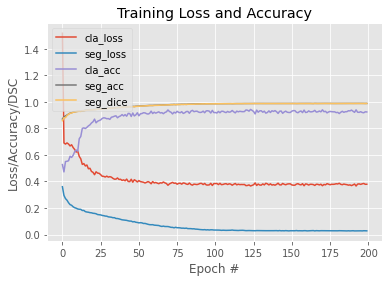

In [10]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["classification_output_loss"], label="cla_loss")
plt.plot(N, hist.history["segmentation_output_loss"], label="seg_loss")

plt.plot(N, hist.history["classification_output_acc"], label="cla_acc")
plt.plot(N, hist.history["segmentation_output_acc"], label="seg_acc")
plt.plot(N, hist.history["seg-out_dice_coef"], label="seg_dice")

# plt.plot(N, hist.history["val_loss"], label="val_loss")
# plt.plot(N, hist.history["val_classification_output_loss"], label="val_cla_loss")
# plt.plot(N, hist.history["val_segmentation_output_loss"], label="val_seg_loss")

# plt.plot(N, hist.history["val_classification_output_acc"], label="val_cla_acc")
# plt.plot(N, hist.history["val_segmentation_output_acc"], label="val_seg_acc")
# plt.plot(N, hist.history["val_seg-out_dice_coef"], label="val_seg_dice")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/DSC")
plt.legend()
plt.savefig(os.path.join('output/', 'shareLayer.png'))


In [11]:
print("------Start predicting------")



predictions_c, predictions_s, predictions_s2 = model.predict([test_x, test_x], batch_size=8)
print("------------------------------------------------ Classification testing ------------------------------------------------")

print(classification_report(test_c_y.argmax(axis=1), predictions_c.argmax(axis=1), target_names=lb.classes_, digits=4))



------Start predicting------
------------------------------------------------ Classification testing ------------------------------------------------
                  precision    recall  f1-score   support

   bengin_images     0.9512    0.9070    0.9286        43
malignant_images     0.8261    0.9048    0.8636        21

        accuracy                         0.9062        64
       macro avg     0.8887    0.9059    0.8961        64
    weighted avg     0.9102    0.9062    0.9073        64



In [12]:
print("------------------------------------------------ Segmentation testing ------------------------------------------------")

# evaluate the model
# loss = model.evaluate(test_x, [test_c_y, test_s_y], verbose=0)
loss, cla_loss, seg_loss, seg_loss2, cla_acc, seg_acc, seg_dice_coef = model.evaluate([test_x, test_x], [test_c_y, test_s_y, test_s_y], verbose=0)
print('Test total loss:', loss)
print('Test classification loss:', cla_loss)
print('Test segmentation loss:', seg_loss)

print('Test classification accuracy:', cla_acc)
print('Test segmentation accuracy:', seg_acc)
print('Test segmentation dice_coef:', seg_dice_coef)

preds_c, preds_s, preds_s2 = model.predict([test_x, test_x], batch_size=8, verbose=1)
test_mask = test_s_y.flatten()
pred_mask = preds_s.flatten()
fpr, tpr, thresholds = roc_curve(test_mask, pred_mask, pos_label=1)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Precision, Recall, accuracy, F1, IoU = p_r_f1_iou(test_s_y, preds_s)
# print('Precision:', Precision)
# print('Recall:', Recall)
# print('m_Iou:', IoU)
# print('F1_score:', F1)


------------------------------------------------ Segmentation testing ------------------------------------------------
Test total loss: 0.40624094009399414
Test classification loss: 0.6795461773872375
Test segmentation loss: 0.17994719371199608
Test classification accuracy: 0.90625
Test segmentation accuracy: 0.9577132165431976
Test segmentation dice_coef: 0.9570378661155701
64/64 [==============================] - 1s 11ms/step
AUC: 0.9861808123254797


In [13]:
print("------------------------------------------------ Segmentation testing ------------------------------------------------")

preds_c, preds_s, preds_s2 = model.predict([test_x, test_x], batch_size=8, verbose=1)
test_mask = test_s_y.flatten()
pred_mask = preds_s2.flatten()
fpr, tpr, thresholds = roc_curve(test_mask, pred_mask, pos_label=1)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)


Precision, Recall, accuracy, F1, IoU = p_r_f1_iou(test_s_y, preds_s2)
print('Precision:', Precision)
print('Recall:', Recall)
print('m_Iou:', IoU)
print('F1_score:', F1)


------------------------------------------------ Segmentation testing ------------------------------------------------
64/64 [==============================] - 1s 11ms/step
AUC: 0.9863036760019435
Precision: 0.6888260315094237
Recall: 0.7184704790098442
m_Iou: 0.5424196575677316
F1_score: 0.7033360277877715
